# 모델에 대한 설명1_PFI
* Permutation Feature Importance


## 1.환경준비

### 1) 라이브러리 로딩

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import * 

from keras.models import Sequential
from keras.layers import Dense
from keras.backend import clear_session

### 2) 데이터 로딩

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/DA4BAM/dataset/master/boston.csv')
data.head()

* 변수 설명
    * crim : 범죄율
    * zn : 대저택 비율
    * indus : 산업단지 비율
    * chas : 찰스 강변 여부
    * nox : 일산화질소 농도(공기오염도)
    * rm : 평균 주택당 방 수
    * age : 30년 이상된 주택 비율
    * dis : 주요 업무 지역 접근성 지수
    * rad : 고속도로 접근성 지수
    * tax  1만 달러당 재산세
    * ptratio : 교사 1명당 학생수
    * lstat : 하위계층 비율
    * black : 흑인비율(원래 숫자를 변형한 것임)
    * mdev : 타운별 집값 중위수(단위 : 1000달러)

### 3) 필요한 함수 생성

In [ ]:
# 변수 중요도 plot
def plot_feature_importance(importance, names, topn = 'all'):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.grid()

    return fi_df

## 2.데이터 준비


### 1) x, y로 나누기 

In [ ]:
target = 'medv'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

### 2) 가변수화

### 3) train : validation 분할

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state = 2022)
x_train.shape

### 4) 스케일링

In [ ]:
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

## 3.Permutation Feature Importance

* model1 : SVM
* model2 : DL 

In [ ]:
from sklearn.inspection import permutation_importance

### 1) SVM 모델

In [ ]:
model1 = SVR()
model1.fit(x_train_s, y_train)

* permutation feature importance 구하기

In [ ]:
pfi1 = permutation_importance(model1, x_val_s, y_val, n_repeats=10, 
                              scoring = 'r2', random_state=20)

In [ ]:
list(x_train)

In [ ]:
pfi1

In [ ]:
pfi1.importances

* feature별 Score 분포

In [ ]:
plt.figure(figsize = (10,8))
for i,vars in enumerate(list(x)) :
    sns.kdeplot(pfi1.importances[i], label = vars)

plt.grid()
plt.legend()
plt.show()

In [ ]:
sorted_idx = pfi1.importances_mean.argsort()
plt.figure(figsize = (10, 8))
plt.boxplot(pfi1.importances[sorted_idx].T, vert=False, labels=x.columns[sorted_idx])
plt.axvline(0, color = 'r')
plt.grid()
plt.show()

* 평균값으로 변수중요도 그래프 그리기 

In [ ]:
result = plot_feature_importance(pfi1.importances_mean, list(x_train))

### 2) DL 모델

* 간단한 DL 모델을 생성해 봅시다.

In [ ]:
x_train_s.shape[1]

In [ ]:
nfeatures = x_train_s.shape[1]
clear_session()

model2 = Sequential([Dense(32, input_shape = [nfeatures,], activation = 'relu'),
                     Dense(8, activation = 'relu'),
                     Dense(1)
                     ])

model2.compile(optimizer = 'adam', loss = 'mse')
history = model2.fit(x_train_s, y_train, epochs = 200, validation_split = .2).history

* permutation feature importance 구하기
    * deep learning 모델에 대해서는 명시적으로 scoring = 'r2'을 지정해 줘야 합니다.

In [ ]:
pfi2 = permutation_importance(model2, x_val_s, y_val, n_repeats=10, 
                              scoring = 'r2', random_state=20)

In [ ]:
pfi2

* feature별 Score 분포

In [ ]:
plt.figure(figsize = (12,8))
for i,vars in enumerate(list(x)) :
    sns.kdeplot(pfi2.importances[i], label = vars)

plt.legend()
plt.show()

In [ ]:
sorted_idx = pfi2.importances_mean.argsort()
plt.figure(figsize = (12,8))
plt.boxplot(pfi2.importances[sorted_idx].T, vert=False, labels=x.columns[sorted_idx])
plt.axvline(0, color = 'r')
plt.grid()
plt.show()

* 평균값으로 변수중요도 그래프 그리기 

In [ ]:
result = plot_feature_importance(pfi2.importances_mean, list(x_train))

In [ ]:
from sklearn.metrics import *

In [ ]:
pred1 = model1.predict(x_val_s)
print(mean_absolute_error(y_val, pred1))

In [ ]:
pred2 = model2.predict(x_val_s)
print(mean_absolute_error(y_val, pred2))

## 4.실습 : 직원 이직 예측모델 변수 중요도 비교

### 1) 데이터 준비

* 데이터 로딩

In [3]:
# data data
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/Attrition2.csv"
data = pd.read_csv(path)
data.head(10)

,Attrition,Age,Department,DistanceFromHome,Education,EducationField,Gender,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,RelationshipSatisfaction,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany
0,0,28,Research & Development,1,3,Medical,Female,Research Scientist,1,Married,3591,1,3,3,3,3,3
1,1,37,Research & Development,2,2,Other,Male,Laboratory Technician,3,Single,2090,6,2,7,3,3,0
2,0,27,Research & Development,8,5,Life Sciences,Male,Laboratory Technician,3,Married,4621,1,4,3,4,3,3
3,0,18,Research & Development,1,3,Life Sciences,Female,Laboratory Technician,4,Single,1611,1,3,0,5,4,0
4,0,29,Research & Development,9,3,Life Sciences,Male,Research Scientist,3,Married,2451,6,1,5,2,2,1
5,0,44,Research & Development,2,1,Medical,Male,Manufacturing Director,3,Single,10209,5,2,16,2,2,2
6,0,41,Sales,10,2,Life Sciences,Male,Sales Executive,4,Single,6230,7,4,16,3,3,14
7,0,25,Sales,18,1,Life Sciences,Male,Sales Executive,3,Married,6232,2,2,6,3,2,3
8,0,50,Research & Development,2,3,Medical,Male,Research Director,3,Married,17639,5,4,30,3,3,4
9,0,47,Sales,4,2,Life Sciences,Female,Sales Executive,4,Single,4163,1,3,9,0,3,9


|	변수 명	|	내용	|	구분	|
|	----	|	----	|	----	|
|	**Attrition**	|	이직여부, Yes = 1 , No = 0	|	**Target**	|
|	Age	|	나이	|	숫자	|
|	BusinessTravel	|	출장 빈도(범주)	|		|
|	Department	|	현 부서	|		|
|	DistanceFromHome	|	집-직장 거리(마일)	|	숫자	|
|	Education	|	교육수준(범주)	|	1 Below College, 2 College, 3 Bachelor, 4 Master, 5 Doctor	|
|	EducationField	|	전공	|		|
|	EnvironmentSatisfaction	|	근무환경에 대한 만족도(범주)	|	1 Low, 2 Good, 3 Excellent, 4 Outstanding	|
|	Gender	|	성별	|		|
|	JobInvolvement	|	직무 적극성(참여도)	|	1 Low, 2 Medium, 3 High, 4 Very High	|
|	JobRole	|	직무	|		|
|	JobSatisfaction	|	직무 만족도	|	1 Low, 2 Medium, 3 High, 4 Very High	|
|	MaritalStatus	|	결혼상태	|		|
|	MonthlyIncome	|	월급	|	숫자	|
|	NumCompaniesWorked	|	현재까지 근무한 회사 수	|	숫자	|
|	PercentSalaryHike	|	전년대비 급여인상율(%)	|	숫자	|
|	RelationshipSatisfaction	|	동료와의 관계 만족도	|	1 Low, 2 Medium, 3 High, 4 Very High	|
|	StockOptionLevel	|	스톡옵션 수준 0~3	|	범주	|
|	TotalWorkingYears	|	총 근무 연수	|	숫자	|
|	TrainingTimesLastYear	|	전년 교육훈련 횟수	|	숫자	|
|	WorkLifeBalance	|	워라밸. 일-삶 균형도	|	1 Bad, 2 Good, 3 Better, 4 Best	|
|	YearsAtCompany	|	현직장 근무 연수	|	숫자	|
|	YearsInCurrentRole	|	현직무 연수	|	숫자	|
|	YearsWithCurrManager	|	현 팀장과 근무한 연수	|	숫자	|


In [4]:
target = 'Attrition'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

In [5]:
y.value_counts() / y.shape[0]

0    0.913043
1    0.086957
Name: Attrition, dtype: float64

* 가변수화 Dummy Variable

In [6]:
dummy_vars = ['Education','Department','EducationField','Gender','JobRole','JobSatisfaction','MaritalStatus',
              'RelationshipSatisfaction','WorkLifeBalance'] # 가변수화 대상 변수 이름 리스트 만든다
x = pd.get_dummies(x, columns = dummy_vars, drop_first=True) 

* 데이터 분할
    * 이미 test set은 분할되어 있다고 가정합니다.
    * 주어진 데이터를 train set : validation set 으로 분할

In [7]:
# train_val에서 train : val = 8 : 2
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state = 20)

In [8]:
print(x_train.shape, x_val.shape)

(920, 38) (230, 38)


* class balance를 맞추기 위한 resampling

In [9]:
from imblearn.over_sampling import SMOTE

In [10]:
smote = SMOTE()
sm_x_train, sm_y_train = smote.fit_resample(x_train, y_train)

* 스케일링

In [11]:
scaler = MinMaxScaler()
sm_x_train_s = scaler.fit_transform(sm_x_train)
x_val_s = scaler.transform(x_val)

### 2) 모델링 및 변수 중요도 계산하기

* model1 : SVM
* model2 : KNN

In [12]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV

#### ① SVM 모델

* 모델링

In [16]:
from sklearn.svm import SVC
model = SVC()
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
             'gamma': [0.001, 0.01, 0.1, 1, 10, 100] }
model1 = GridSearchCV(model, param_grid,cv=3)
model1.fit(sm_x_train_s, sm_y_train)

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]})

In [35]:
model1.best_params_

{'C': 10, 'gamma': 1}

* permutation feature importance 구하기

In [17]:
pfi1 = permutation_importance(model1, x_val_s, y_val, n_repeats=10, scoring='r2' ,random_state=20)

In [18]:
pfi1

{'importances_mean': array([ 0.00000000e+00,  0.00000000e+00, -5.02622378e-03, -5.02622378e-03,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  3.51835664e-02,
        -1.00524476e-02, -2.01048951e-02,  0.00000000e+00, -2.01048951e-02,
        -2.01048951e-02,  6.66133815e-17, -1.00524476e-02, -8.04195804e-02,
        -5.02622378e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.50786713e-02, -5.02622378e-03,  0.00000000e+00, -5.02622378e-03,
         0.00000000e+00, -1.00524476e-02, -5.02622378e-03, -5.02622378e-03,
         5.02622378e-02,  1.05550699e-01, -2.01048951e-02, -3.01573427e-02,
         0.00000000e+00, -2.01048951e-02,  4.52360140e-02, -2.01048951e-02,
         6.03146853e-02,  0.00000000e+00]),
 'importances_std': array([0.        , 0.        , 0.01507867, 0.01507867, 0.        ,
        0.        , 0.        , 0.02303305, 0.03015734, 0.02462337,
        0.        , 0.02462337, 0.02462337, 0.03893296, 0.0201049 ,
        0.02462337, 0.0150786

* feature별 Score 분포

In [19]:
pfi1.importances

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.05026224,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.05026224,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        

In [22]:
pfi1.importances_mean.argsort()

array([ 0.00000000e+00,  0.00000000e+00, -5.02622378e-03, -5.02622378e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  3.51835664e-02,
       -1.00524476e-02, -2.01048951e-02,  0.00000000e+00, -2.01048951e-02,
       -2.01048951e-02,  6.66133815e-17, -1.00524476e-02, -8.04195804e-02,
       -5.02622378e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.50786713e-02, -5.02622378e-03,  0.00000000e+00, -5.02622378e-03,
        0.00000000e+00, -1.00524476e-02, -5.02622378e-03, -5.02622378e-03,
        5.02622378e-02,  1.05550699e-01, -2.01048951e-02, -3.01573427e-02,
        0.00000000e+00, -2.01048951e-02,  4.52360140e-02, -2.01048951e-02,
        6.03146853e-02,  0.00000000e+00])

* 평균값으로 변수중요도 그래프 그리기 

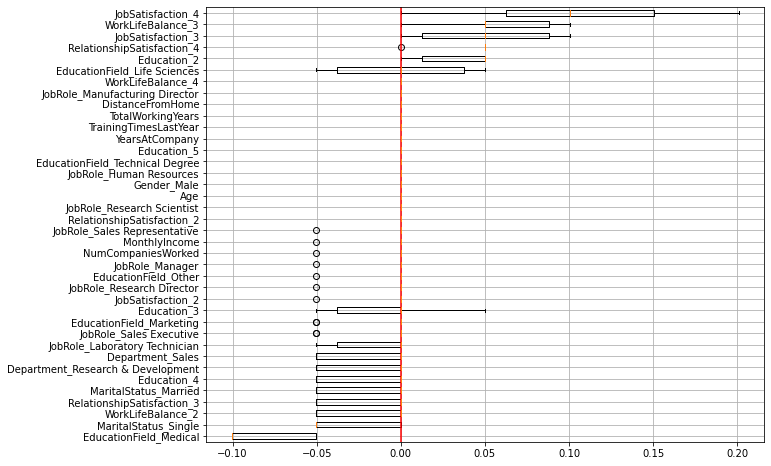

In [26]:
sorted_idx = pfi1.importances_mean.argsort()

plt.figure(figsize=(10,8))
plt.boxplot(pfi1.importances[sorted_idx].T, vert=False, labels=x_train.columns[sorted_idx])
plt.axvline(0, color='r')
plt.grid()
plt.show()

* 예측 및 평가

In [30]:
from sklearn.metrics import *

In [32]:
y_pred = model1.predict(x_val_s)
accuracy_score(y_val, y_pred)

0.9

#### ② KNN 모델

* 모델링

* permutation feature importance 구하기

* feature별 Score 분포

* 평균값으로 변수중요도 그래프 그리기 